In [1]:
%matplotlib inline


In [2]:
import pandas as pd 

In [3]:
import sys 
sys.path.append('../../../')


In [4]:
import matplotlib.pyplot as plt 

In [5]:
from omd2l.utils.io_utils import *

In [6]:
import  omd2l.config as cfg

In [7]:
from omd2l.RecSys.utils import *

In [8]:
from omd2l.utils.compute import try_all_gpus

In [9]:
data, num_users, num_items = read_data_ml100k()
sparsity = 1 - len(data) / (num_users * num_items)
print(f'number of users: {num_users}, number of items: {num_items}')
print(f'matrix sparsity: {sparsity:f}')
print(data.head(5))

number of users: 943, number of items: 1682
matrix sparsity: 0.936953
   user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596


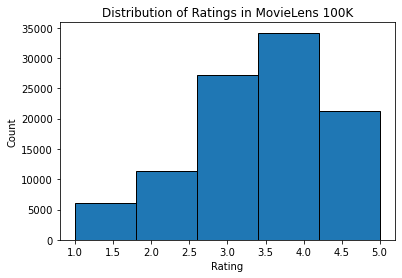

In [10]:
plt.hist(data['rating'], bins=5, ec='black')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings in MovieLens 100K')
plt.show()

## Matrix Factorization 

In [11]:
from omd2l.RecSys.evaluation import *

In [12]:
from omd2l.RecSys.MF import *

In [13]:
from omd2l.RecSys.training import *

In [14]:
devices = try_all_gpus()

In [15]:
num_users, num_items, train_iter, test_iter = split_and_load_ml100k(
    test_ratio=0.1, batch_size=512)

In [16]:
net = MF(30, num_users, num_items)

In [17]:
devices = [torch.device("cuda" if torch.cuda.is_available() else "cpu")]


In [18]:
devices

[device(type='cpu')]

train loss 0.334, test RMSE 1.029
50035.5 examples/sec on cpu


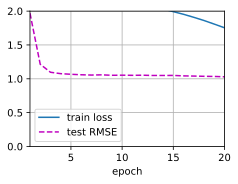

In [19]:

net.to(devices[0])

lr, num_epochs, wd = 0.002, 20, 1e-5
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
loss_fn = nn.MSELoss()

train_recsys_rating(net, train_iter, test_iter, loss_fn, optimizer, num_epochs, devices[0], evaluator)

## AutoRec: Rating Prediction with Autoencoders

In [20]:
from omd2l.RecSys.AutoRec import *

In [21]:
net = AutoRec(500, num_users)


In [22]:
df, num_users, num_items = read_data_ml100k()


In [23]:
train_data, test_data = split_data_ml100k(df, num_users, num_items)


In [24]:
_, _, _, train_inter_mat = load_data_ml100k(train_data, 
                                            num_users,
                                                num_items)
_, _, _, test_inter_mat = load_data_ml100k(test_data, 
                                           num_users,
                                               num_items)

In [25]:
train_inter_mat.shape

(1682, 943)

In [26]:
train_inter_mat

array([[5., 4., 0., ..., 0., 0., 0.],
       [3., 0., 0., ..., 0., 0., 5.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [27]:
test_inter_mat.shape

(1682, 943)

In [28]:
test_inter_mat

array([[0., 0., 0., ..., 5., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [29]:
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(torch.tensor(train_inter_mat, dtype=torch.float32))
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=256, num_workers= 4)

test_dataset = TensorDataset(torch.tensor(test_inter_mat, dtype=torch.float32))
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=1024, num_workers= 4)


TypeError: forward() missing 1 required positional argument: 'input'

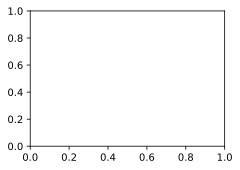

In [30]:

net.to(devices[0])
# Initializing network parameters
# init_params(net)  # You'll need to define this function to initialize the parameters
lr, num_epochs, wd = 0.002, 20, 1e-5
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
loss_fn = nn.MSELoss()

train_recsys_rating(net,
                    train_loader, 
                    test_loader,
                    loss_fn, 
                    optimizer, 
                    num_epochs,
                    devices[0], 
                    evaluator_autorec,
                    inter_mat=test_inter_mat)